## Climate Data Time-Series

Location: Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany
Time-frame: Jan 10, 2009 - December 31, 2017

Index  |   Features         |   Format                |   Description
-------|--------------------|-------------------------|-----------------------
1      |   Date Time        |   01.01.2009 00:10:00   |   Date-time reference
2      |   p (mbar)         |   996.52                |   The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3      |   T (degC)         |   -8.02                 |   Temperature in Celsius
4      |   Tpot (K)         |   265.4                 |   Temperature in Kelvin
5      |   Tdew (degC)      |   -8.9                  |   Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses. 
6      |   rh (%)           |   93.3                  |   Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects. 
7      |   VPmax (mbar)     |   3.33                  |   Saturation vapor pressure
8      |   VPact (mbar)     |   3.11                  |   Vapor pressure
9      |   VPdef (mbar)     |   0.22                  |   Vapor pressure deficit
10     |   sh (g/kg)        |   1.94                  |   Specific humidity
11     |   H2OC (mmol/mol)  |   3.12                  |   Water vapor concentration
12     |   rho (g/m ** 3)   |   1307.75               |   Airtight
13     |   wv (m/s)         |   1.03                  |   Wind speed 
14     |   max. wv (m/s)    |   1.75                  |   Maximum wind speed
15     |   wd (deg)         |   152.3                 |   Wind direction in degrees  


In [4]:
import os
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import keras as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [5]:
SEED_VALUE = 10

tf.random.set_seed(SEED_VALUE)

print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12169935810714671168
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8585731404517075124
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 371595336520166586
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6945894560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11475181465578127378
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [6]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = False
session = InteractiveSession(config=config)

In [7]:
csv_path = './jena_climate_2009_2016.csv'
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
titles = ['Pressure', "Temperature", "Temperature in Kelvin", "Temperature (dew point)", "Relative Humidity", "Saturation vapor pressure", "Vapor pressure", "Vapor pressure deficit", "Specific humidity", "Water vapor concentration", "Airtight", "Wind speed", "Maximum wind speed", "Wind direction in degrees"]

feature_keys = ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

## Min-Max Feature Scaling Normalization

Due to the different units of measure in the dataset, this data will need normalized to get all values between 0 and 1. The below cell normalizes the data using min-max normalization.

In [10]:
def normalize(df, type='mean'):
    data = df.copy()
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        feature = data[key].values
        feature_mean = feature.mean()
        feature_norm = (feature - feature_mean)
        
        if type == 'mean':
            feature_norm /= (feature.max() - feature.min())
        else:
            feature_norm /= feature.std()
            
        data[key] = feature_norm
    return data

In [11]:
def show_visualization(data):
    time_data = data['Date Time']
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(
        15, 20), dpi=80, facecolor='w', edgecolor='k')
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 2, i % 2], color=c,
                         title='{} - {}'.format(titles[i], key), rot=25)
        ax.legend([titles[i]])
    plt.tight_layout()

### Visualization after feature scaling

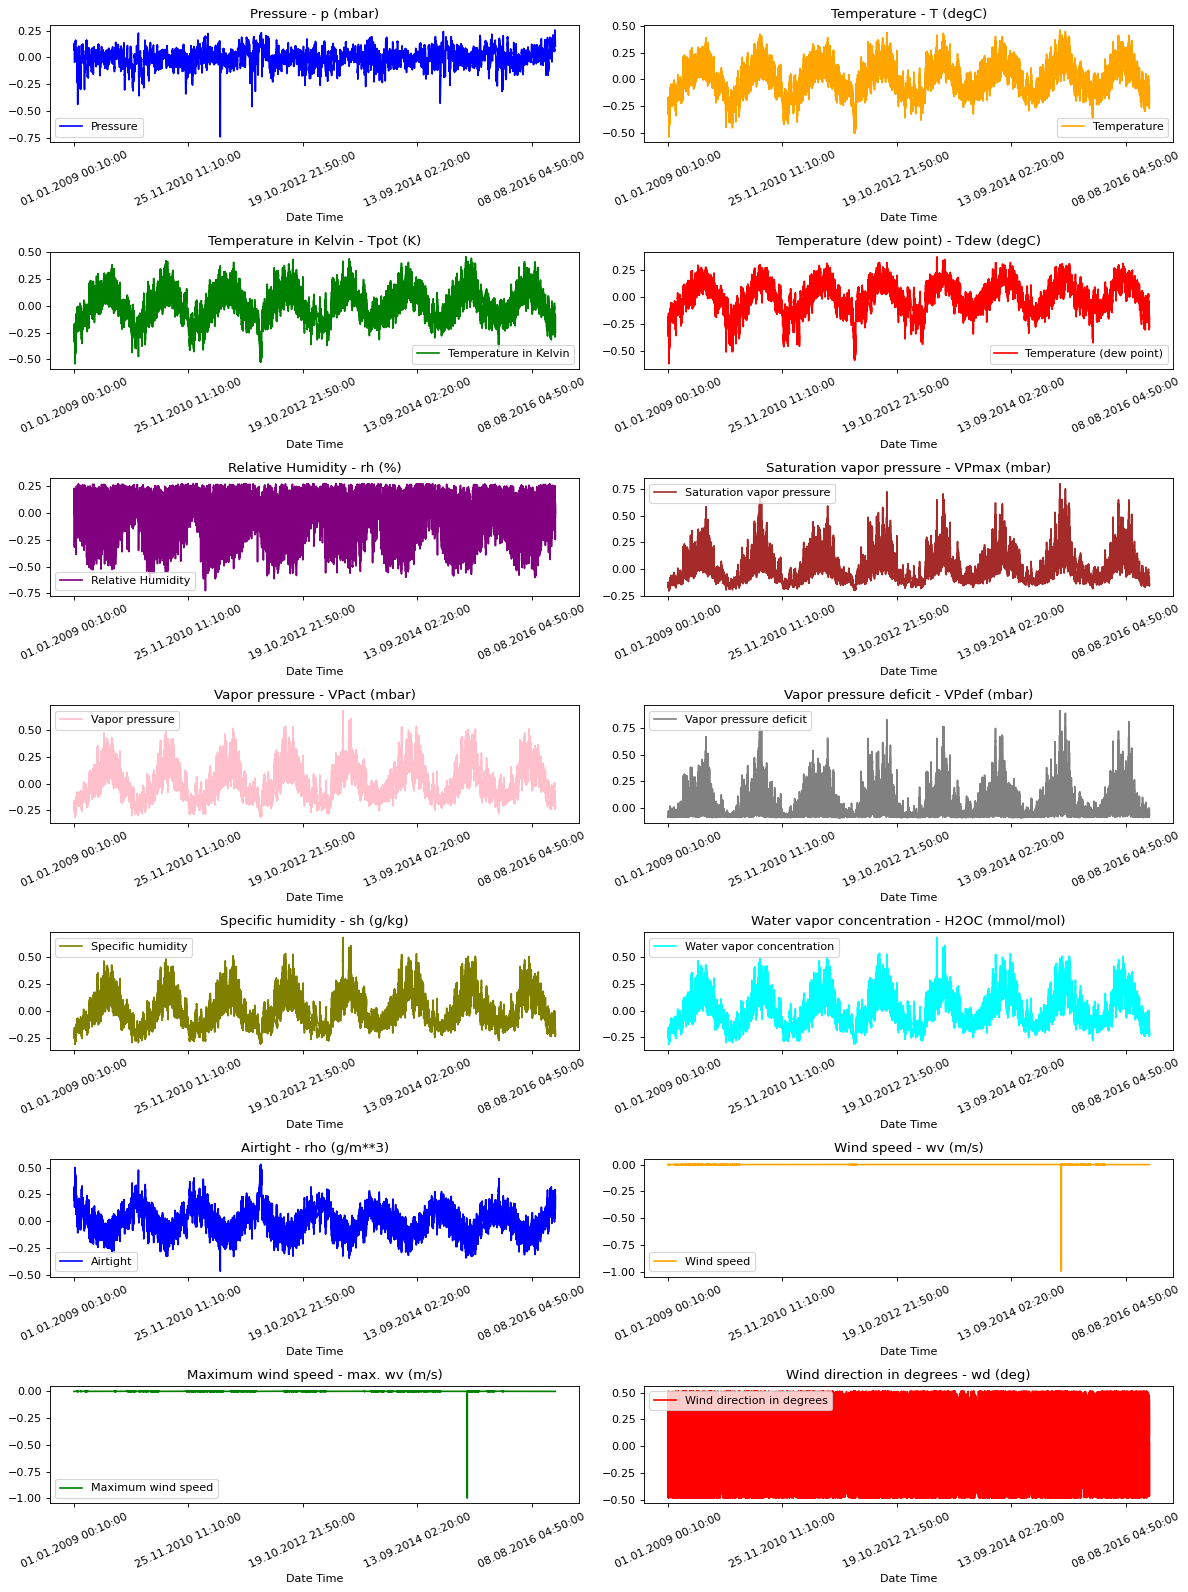

In [12]:
df_scaled = normalize(df, 'mean')
show_visualization(df_scaled)

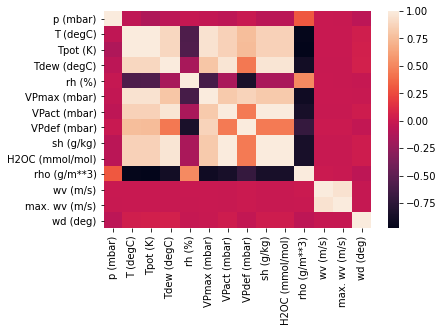

In [13]:
corr = df_scaled.corr()
sns.heatmap(corr)

In [14]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [15]:
df_scaled.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05,4.205510e+05
mean,4.617883e-15,1.243510e-17,5.939113e-16,-6.217551e-18,4.473933e-17,3.135808e-17,6.717658e-17,8.109849e-18,-8.055783e-17,-6.352715e-18,6.336495e-16,1.336462e-20,-4.718866e-20,-2.216692e-17
std,8.214723e-02,1.397141e-01,1.400143e-01,1.398727e-01,1.892725e-01,1.231936e-01,1.519856e-01,1.064301e-01,1.506602e-01,1.511561e-01,1.196540e-01,6.526729e-03,6.886199e-03,2.407825e-01
min,-7.431231e-01,-5.384002e-01,-5.415335e-01,-6.227318e-01,-7.243913e-01,-2.009909e-01,-3.176083e-01,-8.785941e-02,-3.132393e-01,-3.154969e-01,-4.687741e-01,-9.973286e-01,-9.979602e-01,-4.853993e-01
25%,-4.926561e-02,-1.010142e-01,-9.981468e-02,-9.800195e-02,-1.240466e-01,-9.226760e-02,-1.207321e-01,-6.895048e-02,-1.192517e-01,-1.195654e-01,-8.552410e-02,-7.102713e-05,-1.293645e-04,-1.384548e-01
50%,3.609080e-03,-5.000390e-04,-3.744394e-04,5.489322e-03,3.781437e-02,-2.795687e-02,-2.447352e-02,-4.026106e-02,-2.452685e-02,-2.427634e-02,-6.802801e-03,5.761776e-06,-9.633850e-06,6.487850e-02
75%,5.412505e-02,9.984828e-02,9.939507e-02,1.062790e-01,1.538396e-01,6.405204e-02,1.022973e-01,2.733294e-02,1.008277e-01,1.017051e-01,7.994029e-02,1.154602e-04,1.679665e-04,1.648785e-01
max,2.568769e-01,4.615998e-01,4.584665e-01,3.772682e-01,2.756087e-01,7.990091e-01,6.823917e-01,9.121406e-01,6.867607e-01,6.845031e-01,5.312259e-01,2.671434e-03,2.039755e-03,5.146007e-01


In [16]:
df2=df.copy()
df2.head()
df2['Date Time']=pd.to_datetime(df2['Date Time'])
df2.index=df2['Date Time']

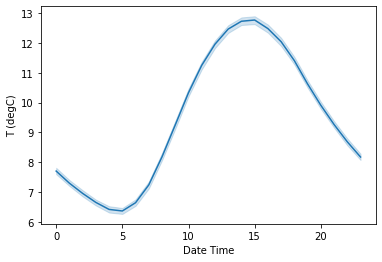

In [13]:
sns.lineplot(x=df2.index.hour,y=df2['T (degC)'])


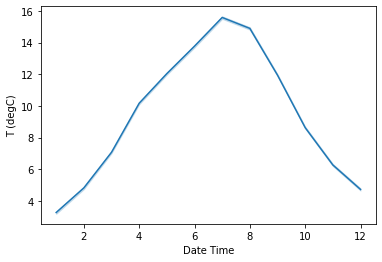

In [14]:
sns.lineplot(x=df2.index.month,y=df2['T (degC)'])

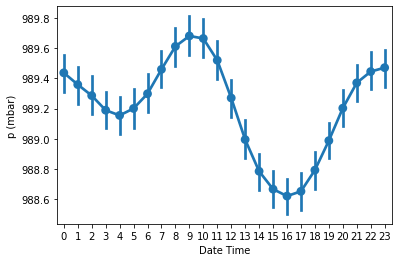

In [15]:
sns.pointplot(x=df2.index.hour, y=df2['p (mbar)'])

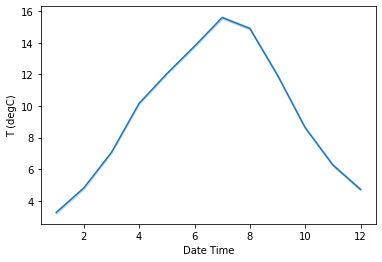

In [16]:
sns.lineplot(x=df2.index.month,y=df2['T (degC)'])

(-20.0, 40.0)

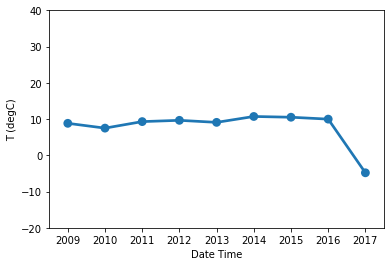

In [17]:
sns.pointplot(x=df2.index.year,y=df2['T (degC)'])
axes = plt.gca()
# axes.set_xlim([xmin,xmax])

axes.set_ylim([-20,40])

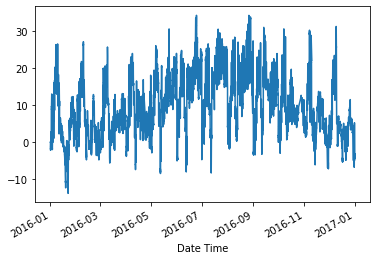

In [18]:
df2['T (degC)']['2016':].plot()

# Training and LSTM section

In [17]:
df['Date Time']=pd.to_datetime(df['Date Time'])
df.index=df['Date Time']
df.drop(columns='Date Time',inplace=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [18]:
target_names = ['p (mbar)',	'T (degC)',	'sh (g/kg)'] #3 features for now

In [19]:
#Predicting the values for 1 week
shift_days=7
obs_per_hour=6
shift_steps=shift_days*obs_per_hour*24

In [20]:
df_targets=df[target_names].shift(-shift_steps)

In [21]:
df_targets.head()

,p (mbar),T (degC),sh (g/kg)
Date Time,,,
2009-01-01 00:10:00,998.67,-10.60,1.56
2009-01-01 00:20:00,998.71,-10.72,1.53
2009-01-01 00:30:00,998.83,-11.29,1.45
2009-01-01 00:40:00,998.96,-11.81,1.38
2009-01-01 00:50:00,999.04,-11.78,1.40


In [22]:
df[target_names].head(shift_steps+5)

,p (mbar),T (degC),sh (g/kg)
Date Time,,,
2009-01-01 00:10:00,996.52,-8.02,1.94
2009-01-01 00:20:00,996.57,-8.41,1.89
2009-01-01 00:30:00,996.53,-8.51,1.88
2009-01-01 00:40:00,996.51,-8.31,1.92
2009-01-01 00:50:00,996.51,-8.27,1.92
...,...,...,...
2009-08-01 00:10:00,998.67,-10.60,1.56
2009-08-01 00:20:00,998.71,-10.72,1.53
2009-08-01 00:30:00,998.83,-11.29,1.45


In [23]:
df_targets.shape, df.shape

((420551, 3), (420551, 14))

In [24]:
df_targets.tail()

,p (mbar),T (degC),sh (g/kg)
Date Time,,,
2016-12-31 23:20:00,NaN,NaN,NaN
2016-12-31 23:30:00,NaN,NaN,NaN
2016-12-31 23:40:00,NaN,NaN,NaN
2016-12-31 23:50:00,NaN,NaN,NaN
2017-01-01 00:00:00,NaN,NaN,NaN


In [25]:
x_data=df.values[:-shift_steps]
x_data.shape

(419543, 14)

In [26]:
y_data=df_targets[:-shift_steps]
y_data.shape

(419543, 3)

In [27]:
train_split = 0.9
num_data=len(x_data)
num_train = int(train_split * num_data)
num_test = num_data - num_train

In [28]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

419543

In [29]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

419543

# Scaling 

In [30]:
from sklearn.preprocessing import RobustScaler


In [31]:
scaler_x=RobustScaler()
x_train_scaled=scaler_x.fit_transform(x_train)
x_test_scaled=scaler_x.transform(x_test)

In [32]:
scaler_y=RobustScaler()
y_train_scaled=scaler_y.fit_transform(y_train)
y_test_scaled=scaler_y.transform(y_test)

In [33]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)


(377588, 14)
(377588, 3)


In [34]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_features)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)
        


In [35]:
batch_size = 64
num_x_features=x_data.shape[1]
num_y_features=y_data.shape[1]

In [36]:
sequence_length=6*24*7

In [37]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [38]:
x_batch, y_batch = next(generator)

In [39]:
print(x_batch.shape)
print(y_batch.shape)

(64, 1008, 14)
(64, 1008, 3)


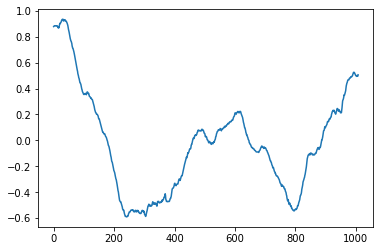

In [40]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)


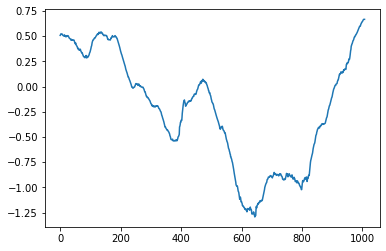

In [41]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [42]:

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [43]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.activations import relu, softmax
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

In [44]:
model=Sequential()
model.add(LSTM(units=512, return_sequences=True,input_shape=(None,num_x_features,)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=3,activation='softmax'))

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [56]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

In [57]:
path_checkpoint = 'model_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [58]:
history = model.fit(x=generator,
                    epochs=25,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=callback_checkpoint)

RuntimeError: You must compile your model before using it.

In [49]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

In [50]:
#load checkpoint
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'model_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [51]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [62]:
print(result)

NameError: name 'result' is not defined

In [ ]:
session.close()